# Feature Importance

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy import sort
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,f1_score
from sklearn.feature_selection import SelectFromModel
import seaborn as sns
from IPython.display import clear_output

# Moudule Consts

In [2]:
    features=\
    [
     'stay_duration', #f1
     'mfcc0','mfcc1','mfcc2','mfcc3','mfcc4', #f2,f3,f4,f5,f6
     'wifi_count', 'edge_wifi_count', #f7,f8
     'RSI', #f9
     'human_made', 'natural_land','road_exist_percent','highly_populated_poi_exist'#f10,f11,f12,f13
     ]

    labels=['Is_Bus_stop','Is_Turn', 'Is_Signal','Is_Congestion', 'Is_Adhoc']

####FEATURES ARE NAMED IN THIS FASHION##############################################
    feature_namming=\
    {
     'stay_duration':"$\mathbf{f_{1}}$", #f1
     'mfcc0':"$\mathbf{f_{2}}$",'mfcc1':"$\mathbf{f_{3}}$",'mfcc2':"$\mathbf{f_{4}}$",'mfcc3':"$\mathbf{f_{5}}$",'mfcc4':"$\mathbf{f_{6}}$", #f2,f3,f4,f5,f6
     'wifi_count':"$\mathbf{f_{7}}$", 'edge_wifi_count':"$\mathbf{f_{8}}$", #f7,f8
     'RSI':"$\mathbf{f_{9}}$", #f9
     'human_made':"$\mathbf{f_{10}}$", 'natural_land':"$\mathbf{f_{11}}$",'road_exist_percent':"$\mathbf{f_{12}}$",'highly_populated_poi_exist':"$\mathbf{f_{13}}$"#f10,f11,f12,f13
     }

# Helper Functions 

In [3]:
class myDict:
    def __init__(self,d):
        self.dic=d
    def normalize(self):
        a=np.array(list(self.dic.values()))
        return myDict(dict(zip(self.dic.keys(),(a-a.min())/a.max())))
    def __repr__(self):
        return str(self.dic)
    def __add__(self,other):
        return myDict(dict(pd.Series(self.dic)+pd.Series(other.dic)))
    def __truediv__(self,val):
        return myDict(dict(zip(self.dic.keys(),np.array(list(self.dic.values()))/val)))
    def keys(self):
        return self.dic.keys()
    def values(self):
        return self.dic.values()
    def get_sorted(self):
        a=list(zip(self.dic.keys(),self.dic.values()))
        return myDict(dict(sorted(a,key=lambda e:e[1])))
    
def get_feature_set_for(target_column):
    df=pd.read_csv('./Datasets/DataSet_54F_mfcc.csv')

    Labels=df[target_column].values
    Features=df[features]

    return Features,Labels

In [4]:
def check_feature_f1_score(target_class,importance_dict,checkfor=30):
    f1_mean_l=[]
    f1_std_l=[]
    fsize=len(importance_dict.keys())
    for feat in range(1,fsize+1):
        f1_l=[]
        taken_feat=list(importance_dict.keys())[-feat:]
        for _ in range(checkfor):
            X,y=get_feature_set_for(target_class)
            X_train, X_test, y_train, y_test = train_test_split(X[taken_feat], y, test_size=0.33, random_state=None,stratify=y)

            model = RandomForestClassifier()#n_estimators=20,max_depth=8)#XGBClassifier()
            model.fit(X_train, y_train)

            f1=f1_score(y_test,model.predict(X_test),average='weighted') #f1 score is calculated
            f1_l.append(f1)
        f1_mean_l.append(np.mean(f1_l))
        f1_std_l.append(np.std(f1_l))

    return f1_mean_l,f1_std_l

In [5]:
feat_columns=features[:] #copy of features array
num_feat=len(feat_columns)
    
def Feature_Importance(target_class,run_cases=100,eachcheckfor=30):
    
    Sum=myDict(dict(zip(feat_columns,[0]*num_feat))) #zero_initilization

    for _ in range(run_cases):
        X,y=get_feature_set_for(target_class)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=None,stratify=y)
        
        print('{}: on run {}'.format(target_class,_))
        model = RandomForestClassifier()#n_estimators=20,max_depth=8)#XGBClassifier()
        model.fit(X_train, y_train)

        Sum+=myDict(dict(zip(X.columns,model.feature_importances_)))

    avg=Sum/run_cases
    avg=avg.get_sorted()
    
    print('checking feature adding F1-Score')
    f1_mean_l_c,f1_std_l_c=check_feature_f1_score(target_class,avg,eachcheckfor)
    
    return avg,f1_mean_l_c,f1_std_l_c #returninig (AVG_importance, f1_mean_list, f1_std_list)

# ONLY RUN IF NECESSARY

bus_stop_fi,bus_stop_f1,bus_stop_f1_std=Feature_Importance('Is_Bus_stop',100,30)
norm_road_fi,norm_road_f1,norm_road_f1_std=Feature_Importance('Is_Adhoc',100,30)
Signal_fi,Signal_f1,Signal_f1_std=Feature_Importance('Is_Signal',100,30)
Turn_fi,Turn_f1,Turn_f1_std=Feature_Importance('Is_Turn',100,30)
Congestion_fi,Congestion_f1,Congestion_f1_std=Feature_Importance('Is_Congestion',100,30)
clear_output()

#SAVE IMPORTANCES FOR FUTURE ACCESS
importance={
    'bus':{'imp':bus_stop_fi,'f1_mean':bus_stop_f1,"f1_std":bus_stop_f1_std},
    'turn':{'imp':Turn_fi,'f1_mean':Turn_f1,"f1_std":Turn_f1_std},
    'signal':{'imp':Signal_fi,'f1_mean':Signal_f1,"f1_std":Signal_f1_std},
    'congestion':{'imp':Congestion_fi,'f1_mean':Congestion_f1,"f1_std":Congestion_f1_std},
    'adhoc':{'imp':norm_road_fi,'f1_mean':norm_road_f1,"f1_std":norm_road_f1_std}
}

import pickle
with open('./logs/importance.pickle', 'wb') as handle:
    pickle.dump(importance, handle, protocol=pickle.HIGHEST_PROTOCOL)

print("Importance PICKLE IS SAVED")

# ONLY LOAD IMPORTANCES

In [6]:
#LOAD PREVIOUS CALCULATED IMPORTANCES
import pickle
with open('./logs/importance.pickle', 'rb') as handle:
    IMPORTANCE = pickle.load(handle)

# Plotting

In [7]:
#DRAW CHARTS.....
#Importance
def get_importance_chart(target_fi):
    fig, ax = plt.subplots(figsize=(10,7))

    feats=list(map(lambda name:feature_namming[name],list(target_fi.keys())))
    importances=list(target_fi.values())

    ax.barh(feats,importances,color=sns.color_palette('hot_r',num_feat),ec='k',linewidth=3)

    ax.set_xticks([])
    ax.set_xlabel('Importance',fontsize=22, fontweight='bold')
    ax.set_ylabel('Features',fontsize=22, fontweight='bold')
    plt.yticks(fontsize=22, fontweight='bold')
    ax.grid()
    plt.close()
    return fig

In [8]:
#SAVING ALL FEATURE IMPORTANCES
get_importance_chart(IMPORTANCE["bus"]["imp"]).savefig("./logs/Figures/bus.png")
get_importance_chart(IMPORTANCE["turn"]["imp"]).savefig("./logs/Figures/turn.png")
get_importance_chart(IMPORTANCE["signal"]["imp"]).savefig("./logs/Figures/signal.png")
get_importance_chart(IMPORTANCE["congestion"]["imp"]).savefig("./logs/Figures/congestion.png")
get_importance_chart(IMPORTANCE["adhoc"]["imp"]).savefig("./logs/Figures/adhoc.png")

# Feature Importance Incremental feat performance

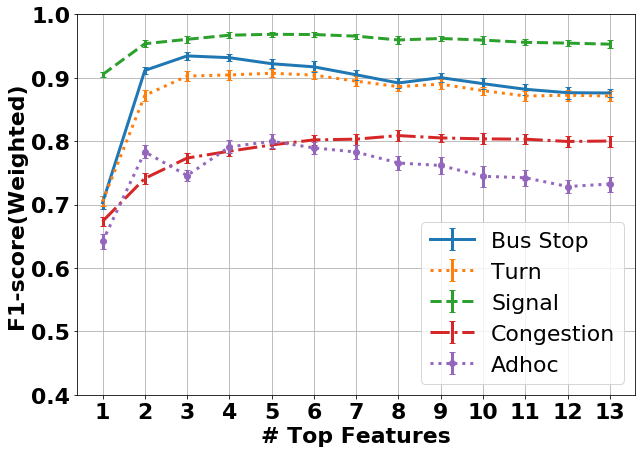

In [9]:
fig, ax = plt.subplots(figsize=(10,7))

ax.errorbar(list(map(str,range(1,num_feat+1))),IMPORTANCE["bus"]["f1_mean"],yerr=IMPORTANCE["bus"]["f1_std"],label='Bus Stop',capsize=3,linewidth=3,linestyle='solid')

ax.errorbar(list(map(str,range(1,num_feat+1))),IMPORTANCE["turn"]["f1_mean"],yerr=IMPORTANCE["turn"]["f1_std"],label='Turn',capsize=3,linewidth=3,linestyle='dotted')

ax.errorbar(list(map(str,range(1,num_feat+1))),IMPORTANCE["signal"]["f1_mean"],yerr=IMPORTANCE["signal"]["f1_std"],label='Signal',capsize=3,linewidth=3,linestyle='dashed')

ax.errorbar(list(map(str,range(1,num_feat+1))),IMPORTANCE["congestion"]["f1_mean"],yerr=IMPORTANCE["congestion"]["f1_std"],label='Congestion',capsize=3,linewidth=3,linestyle='dashdot')

ax.errorbar(list(map(str,range(1,num_feat+1))),IMPORTANCE["adhoc"]["f1_mean"],yerr=IMPORTANCE["adhoc"]["f1_std"],label='Adhoc',capsize=3,linewidth=3,linestyle=':',marker='o')

plt.xlabel("# Top Features",fontsize=22, fontweight='bold')
plt.ylabel("F1-score(Weighted)",fontsize=22, fontweight='bold')

plt.yticks(fontsize=22, fontweight='bold')
plt.xticks(fontsize=22, fontweight='bold')
plt.ylim(0.4,1)

ax.legend(fontsize=22,loc="best")
plt.grid()

fig.savefig("./logs/Figures/overall_f1_progress.png")

# NICE